<a href="https://colab.research.google.com/github/Zuhair0000/FYP-Research/blob/main/FYP_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import os

# List all files in the Colab working directory
print(os.listdir("/content"))

['.config', 'Dataset A', 'Dataset B', '.ipynb_checkpoints', 'ML_DL_Comparison.csv', 'sample_data']


In [125]:
import glob
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [126]:
all_files = glob.glob("/content/Dataset A/*.xlsx")
print("All Excel files:", all_files)

# Separate solar and wind
solar_files = [f for f in all_files if "光伏" in f]
wind_files  = [f for f in all_files if "风力" in f]

print("Solar files:", solar_files)
print("Wind files:", wind_files)

All Excel files: ['/content/Dataset A/风力冬季发电.xlsx', '/content/Dataset A/光伏秋季发电.xlsx', '/content/Dataset A/风力夏季发电.xlsx', '/content/Dataset A/风力秋季发电.xlsx', '/content/Dataset A/光伏冬季发电.xlsx', '/content/Dataset A/光伏春季发电.xlsx', '/content/Dataset A/光伏夏季发电.xlsx', '/content/Dataset A/风力春季发电.xlsx']
Solar files: ['/content/Dataset A/光伏秋季发电.xlsx', '/content/Dataset A/光伏冬季发电.xlsx', '/content/Dataset A/光伏春季发电.xlsx', '/content/Dataset A/光伏夏季发电.xlsx']
Wind files: ['/content/Dataset A/风力冬季发电.xlsx', '/content/Dataset A/风力夏季发电.xlsx', '/content/Dataset A/风力秋季发电.xlsx', '/content/Dataset A/风力春季发电.xlsx']


In [127]:

# Load solar
solar_dfs = [pd.read_excel(f) for f in solar_files]
solar_data = pd.concat(solar_dfs, ignore_index=True)

# Load wind
wind_dfs = [pd.read_excel(f) for f in wind_files]
wind_data = pd.concat(wind_dfs, ignore_index=True)

print("Solar shape:", solar_data.shape)
print("Wind shape:", wind_data.shape)

Solar shape: (8753, 7)
Wind shape: (8752, 5)


In [128]:
print("Solar columns:", solar_data.columns)
print(solar_data.head())

print("\nWind columns:", wind_data.columns)
print(wind_data.head())

print("\nMissing values in Solar:\n", solar_data.isnull().sum())
print("\nMissing values in Wind:\n", wind_data.isnull().sum())

Solar columns: Index(['年份', '时间', '温度', '湿度', '地面辐射强度', '大气上层辐射强度', '光伏发电'], dtype='object')
                   年份  时间      温度     湿度  地面辐射强度  大气上层辐射强度  光伏发电
0 2019-09-01 00:00:00   1  11.281  0.009   0.000     0.000   0.0
1 2019-09-01 01:00:00   2  10.447  0.009   0.000     0.000   0.0
2 2019-09-01 02:00:00   3   9.970  0.009   0.000     0.000   0.0
3 2019-09-01 03:00:00   4   9.942  0.009   0.000     0.000   0.0
4 2019-09-01 04:00:00   5   9.962  0.009   2.222     7.152   0.0

Wind columns: Index(['年份', '时间', '空气密度', '风速', '发电功率'], dtype='object')
                   年份  时间   空气密度     风速      发电功率
0 2019-12-01 00:00:00   1  1.318  8.285  2578.960
1 2019-12-01 01:00:00   2  1.314  7.990  2379.431
2 2019-12-01 02:00:00   3  1.309  7.685  2162.803
3 2019-12-01 03:00:00   4  1.304  7.547  2068.773
4 2019-12-01 04:00:00   5  1.302  7.058  1740.835

Missing values in Solar:
 年份          0
时间          0
温度          0
湿度          0
地面辐射强度      0
大气上层辐射强度    0
光伏发电        0
dtype: int64

Missi

In [129]:
# --- Solar ---
solar_data = solar_data.rename(columns={
    "年份": "DateTime",
    "时间": "Index",
    "温度": "Temperature",
    "湿度": "Humidity",
    "地面辐射强度": "Ground_Irradiance",
    "大气上层辐射强度": "Atmospheric_Irradiance",
    "光伏发电": "Solar_Power"
})

# --- Wind ---
wind_data = wind_data.rename(columns={
    "年份": "DateTime",
    "时间": "Index",
    "空气密度": "Air_Density",
    "风速": "Wind_Speed",
    "发电功率": "Wind_Power"
})

In [130]:
solar_data["DateTime"] = pd.to_datetime(solar_data["DateTime"])
wind_data["DateTime"]  = pd.to_datetime(wind_data["DateTime"])

# Sort by datetime
solar_data = solar_data.sort_values("DateTime")
wind_data  = wind_data.sort_values("DateTime")
solar_data


,DateTime,Index,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power
2928,2019-01-01 08:00:00,745,-19.889,0.001,82.680,209.252,257.690
2929,2019-01-01 09:00:00,746,-19.004,0.001,149.553,345.604,530.391
2930,2019-01-01 10:00:00,747,-17.971,0.001,193.625,430.654,871.016
2931,2019-01-01 11:00:00,748,-17.281,0.001,203.808,458.550,1087.304
2932,2019-01-01 12:00:00,749,-16.738,0.001,185.193,427.391,1010.161
...,...,...,...,...,...,...,...
2923,2019-12-31 19:00:00,740,-23.621,0.000,0.000,0.000,0.000
2924,2019-12-31 20:00:00,741,-23.980,0.000,0.000,0.000,0.000
2925,2019-12-31 21:00:00,742,-24.826,0.000,0.000,0.000,0.000
2926,2019-12-31 22:00:00,743,-26.172,0.000,0.000,0.000,0.000


In [131]:
solar_data = solar_data.drop(columns=["Index"])
wind_data  = wind_data.drop(columns=["Index"])

In [132]:
print("Solar date range:", solar_data["DateTime"].min(), "→", solar_data["DateTime"].max())
print("Wind date range:", wind_data["DateTime"].min(), "→", wind_data["DateTime"].max())

print("\nSolar frequency check:")
print(solar_data["DateTime"].diff().value_counts().head())

print("\nWind frequency check:")
print(wind_data["DateTime"].diff().value_counts().head())

Solar date range: 2019-01-01 08:00:00 → 2019-12-31 23:00:00
Wind date range: 2019-01-01 08:00:00 → 2019-12-31 23:00:00

Solar frequency check:
DateTime
0 days 01:00:00    8751
0 days 00:00:00       1
Name: count, dtype: int64

Wind frequency check:
DateTime
0 days 01:00:00    8751
Name: count, dtype: int64


In [133]:
# Resample Solar
solar_data = solar_data.set_index("DateTime").resample("h").mean().interpolate()

# Resample Wind
wind_data = wind_data.set_index("DateTime").resample("h").mean().interpolate()

# Reset index back
solar_data = solar_data.reset_index()
wind_data  = wind_data.reset_index()

In [134]:
merged_data = pd.merge_asof(
    solar_data.sort_values("DateTime"),
    wind_data.sort_values("DateTime"),
    on="DateTime",
    direction="nearest"  # matches closest timestamp
)
merged_data

,DateTime,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power,Air_Density,Wind_Speed,Wind_Power
0,2019-01-01 08:00:00,-19.889,0.001,82.680,209.252,257.690,1.335,6.178,1203.800
1,2019-01-01 09:00:00,-19.004,0.001,149.553,345.604,530.391,1.337,6.534,1410.415
2,2019-01-01 10:00:00,-17.971,0.001,193.625,430.654,871.016,1.339,6.747,1547.633
3,2019-01-01 11:00:00,-17.281,0.001,203.808,458.550,1087.304,1.340,6.765,1556.072
4,2019-01-01 12:00:00,-16.738,0.001,185.193,427.391,1010.161,1.342,6.606,1456.741
...,...,...,...,...,...,...,...,...,...
8747,2019-12-31 19:00:00,-23.621,0.000,0.000,0.000,0.000,1.385,6.260,1254.654
8748,2019-12-31 20:00:00,-23.980,0.000,0.000,0.000,0.000,1.387,5.784,995.959
8749,2019-12-31 21:00:00,-24.826,0.000,0.000,0.000,0.000,1.388,4.955,614.468
8750,2019-12-31 22:00:00,-26.172,0.000,0.000,0.000,0.000,1.388,4.525,457.358


In [135]:
for lag in [1, 3, 6, 24]:  # 1h, 3h, 6h, 24h lags
    merged_data[f"Solar_Power_lag{lag}"] = merged_data["Solar_Power"].shift(lag)
    merged_data[f"Wind_Power_lag{lag}"] = merged_data["Wind_Power"].shift(lag)

In [136]:
merged_data["Solar_Power_roll6h"] = merged_data["Solar_Power"].rolling(window=6).mean()
merged_data["Wind_Power_roll6h"] = merged_data["Wind_Power"].rolling(window=6).mean()

In [137]:
merged_data["hour"] = merged_data["DateTime"].dt.hour
merged_data["dayofweek"] = merged_data["DateTime"].dt.dayofweek
merged_data["month"] = merged_data["DateTime"].dt.month

In [138]:
merged_data = merged_data.dropna().reset_index(drop=True)

In [139]:
# Path to the clean India dataset
file_path = "/content/Dataset B/January 2024- June 2025.xlsx"

# Load the Excel file
india_df = pd.read_excel(file_path)

# Inspect first rows
print(india_df.head())
print(india_df.shape)

             Timestamp Demand (MW) Wind (MW) Solar (MW) Total Generation (MW)
0  01-01-2024 00:00:00   141981.26   9545.07      20.29             142193.38
1  01-01-2024 01:00:00   138675.49   9027.05      19.96             138792.04
2  01-01-2024 02:00:00   136122.78   8241.48      19.79             136796.02
3  01-01-2024 03:00:00   135806.51   7866.09      19.73             136859.67
4  01-01-2024 04:00:00   139905.77   7430.71      20.02             140561.49
(12990, 5)


In [140]:
# Convert Timestamp column to datetime
india_df["Timestamp"] = pd.to_datetime(india_df["Timestamp"], errors="coerce")

# Drop rows where Timestamp is missing
india_df = india_df.dropna(subset=["Timestamp"])

# Convert numeric columns (they may be read as strings)
num_cols = ["Demand (MW)", "Wind (MW)", "Solar (MW)", "Total Generation (MW)"]
for col in num_cols:
    india_df[col] = pd.to_numeric(india_df[col], errors="coerce")

# Sort chronologically
india_df = india_df.sort_values("Timestamp").reset_index(drop=True)

print(india_df.info())
print(india_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Timestamp              5184 non-null   datetime64[ns]
 1   Demand (MW)            5184 non-null   float64       
 2   Wind (MW)              5184 non-null   float64       
 3   Solar (MW)             5184 non-null   float64       
 4   Total Generation (MW)  5184 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 202.6 KB
None
                 Timestamp    Demand (MW)     Wind (MW)    Solar (MW)  \
count                 5184    5184.000000   5184.000000   5184.000000   
mean   2024-10-21 00:50:00  192456.737118   8740.483189  15899.132461   
min    2024-01-01 00:00:00   97065.280000    636.000000    -49.270000   
25%    2024-05-06 23:45:00  182160.462500   4536.230000     96.275000   
50%    2024-09-21 23:30:00  195634.545000   7645.9

In [141]:
# Select subset of columns
india_df = india_df[["Timestamp", "Demand (MW)", "Wind (MW)", "Solar (MW)", "Total Generation (MW)"]]

print(india_df.head())

            Timestamp  Demand (MW)  Wind (MW)  Solar (MW)  \
0 2024-01-01 00:00:00    141981.26    9545.07       20.29   
1 2024-01-01 01:00:00    138675.49    9027.05       19.96   
2 2024-01-01 02:00:00    136122.78    8241.48       19.79   
3 2024-01-01 03:00:00    135806.51    7866.09       19.73   
4 2024-01-01 04:00:00    139905.77    7430.71       20.02   

   Total Generation (MW)  
0              142193.38  
1              138792.04  
2              136796.02  
3              136859.67  
4              140561.49  


### ***ML for Solar on Dataset A***

In [142]:
# ========== Metrics Function ==========
def get_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [143]:
# ========== Evaluation Function ==========
def evaluate_model(model, X_train, y_train, X_test, y_test, name="Model", target="Solar"):
    preds_train = model.predict(X_train)
    preds_test  = model.predict(X_test)

    rmse, mae, r2 = get_metrics(y_test, preds_test)

    print(f"\n{name} Performance on {target}:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

    # Plot Actual vs Predicted (sample of 200 hours)
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values[:200], label="Actual")
    plt.plot(preds_test[:200], label="Predicted")
    plt.title(f"{name} - {target} Power Prediction (Sample of 200 hours)")
    plt.legend()
    plt.show()

    return {"Target": target, "Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}

In [144]:
# --- Features & Targets ---
solar_features = ["Temperature", "Humidity", "Ground_Irradiance", "Atmospheric_Irradiance"]
wind_features  = ["Air_Density", "Wind_Speed"]

X_solar = merged_data[solar_features]
y_solar = merged_data["Solar_Power"]

X_wind  = merged_data[wind_features]
y_wind  = merged_data["Wind_Power"]

In [145]:
# --- Train-Test Split ---
X_train_solar, X_test_solar, y_train_solar, y_test_solar = train_test_split(X_solar, y_solar, test_size=0.2, shuffle=False)
X_train_wind,  X_test_wind,  y_train_wind,  y_test_wind  = train_test_split(X_wind,  y_wind,  test_size=0.2, shuffle=False)

In [146]:
# --- Scaling ---
scaler_solar = StandardScaler()
X_train_solar = scaler_solar.fit_transform(X_train_solar)
X_test_solar  = scaler_solar.transform(X_test_solar)

scaler_wind = StandardScaler()
X_train_wind = scaler_wind.fit_transform(X_train_wind)
X_test_wind  = scaler_wind.transform(X_test_wind)

# Training For Solar

In [147]:
rf_solar = RandomForestRegressor(n_estimators=200, random_state=42)
rf_solar.fit(X_train_solar, y_train_solar)

RandomForestRegressor(n_estimators=200, random_state=42)

In [148]:
xgb_solar = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_solar.fit(X_train_solar, y_train_solar)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

Training for Wind

In [149]:
rf_wind = RandomForestRegressor(n_estimators=200, random_state=42)
rf_wind.fit(X_train_wind, y_train_wind)

RandomForestRegressor(n_estimators=200, random_state=42)

In [150]:
xgb_wind = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_wind.fit(X_train_wind, y_train_wind)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

## **Evaluation**

In [151]:
results_ml = []


Random Forest Performance on Solar:
RMSE: 390.48, MAE: 171.89, R²: 0.865


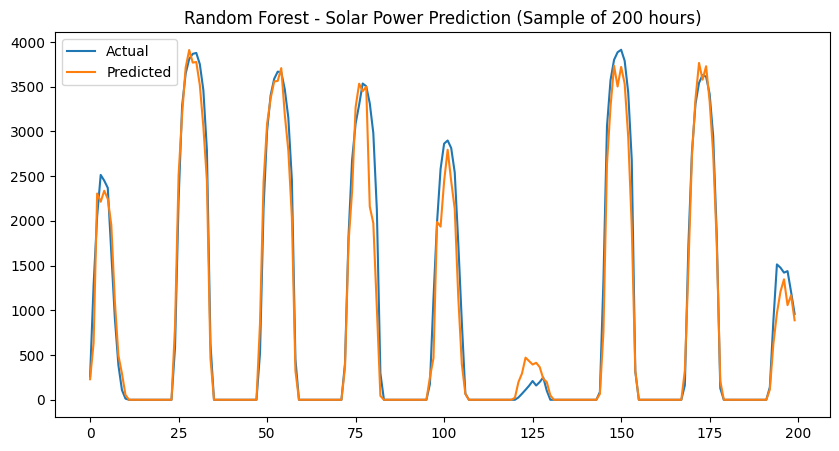


XGBoost Performance on Solar:
RMSE: 394.17, MAE: 178.85, R²: 0.862


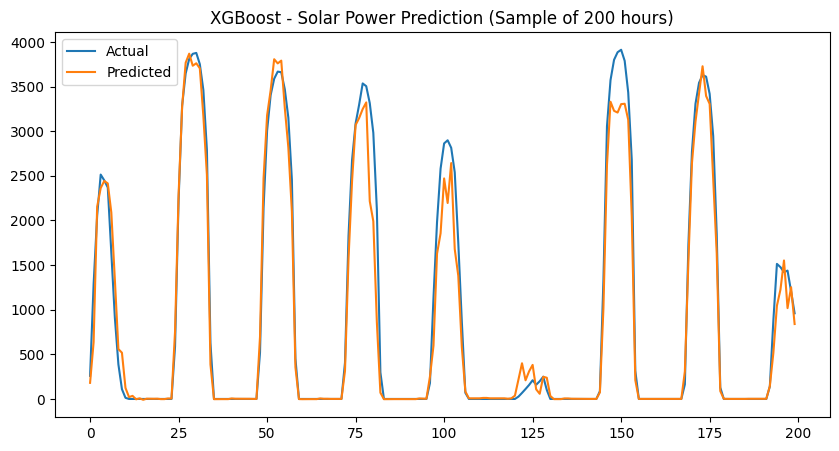

In [152]:
# Solar
results_ml.append(evaluate_model(rf_solar,  X_train_solar, y_train_solar, X_test_solar, y_test_solar, "Random Forest", "Solar"))
results_ml.append(evaluate_model(xgb_solar, X_train_solar, y_train_solar, X_test_solar, y_test_solar, "XGBoost", "Solar"))


Random Forest Performance on Wind:
RMSE: 0.66, MAE: 0.36, R²: 1.000


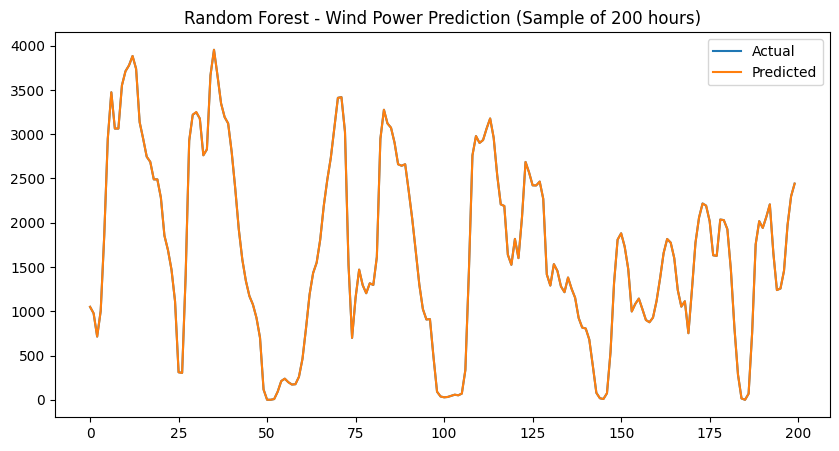


XGBoost Performance on Wind:
RMSE: 8.62, MAE: 5.01, R²: 1.000


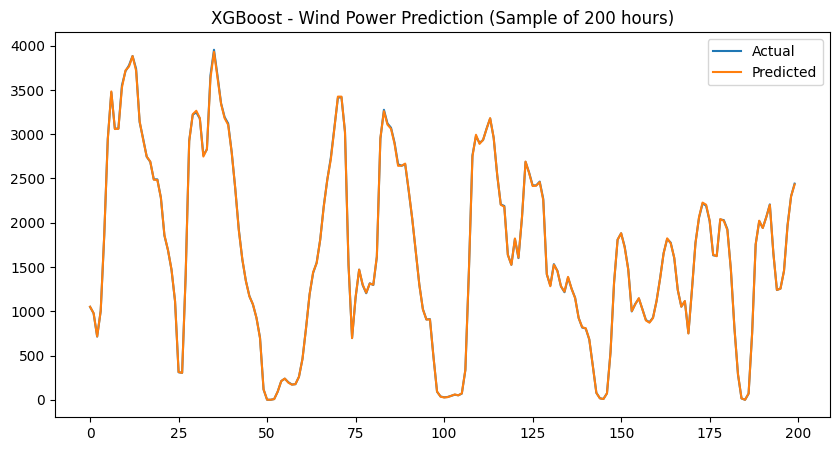

In [153]:
# Wind
results_ml.append(evaluate_model(rf_wind,  X_train_wind, y_train_wind, X_test_wind, y_test_wind, "Random Forest", "Wind"))
results_ml.append(evaluate_model(xgb_wind, X_train_wind, y_train_wind, X_test_wind, y_test_wind, "XGBoost", "Wind"))

In [154]:
# Convert to DataFrame
results_df = pd.DataFrame(results_ml)
print("\nFinal Results:\n", results_df)


Final Results:
   Target          Model        RMSE         MAE        R2
0  Solar  Random Forest  390.483799  171.886996  0.864690
1  Solar        XGBoost  394.166178  178.854385  0.862126
2   Wind  Random Forest    0.662368    0.364053  1.000000
3   Wind        XGBoost    8.615146    5.012414  0.999940


### **DL for Solar dataset A**

In [155]:
# ========== Sequence Builder ==========
def create_sequences(X, y, window_size=24):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

In [156]:
# --- Solar ---
solar_features = ["Temperature", "Humidity", "Ground_Irradiance", "Atmospheric_Irradiance"]
X_solar = merged_data[solar_features].values
y_solar = merged_data["Solar_Power"].values

In [157]:
# --- Wind ---
wind_features = ["Air_Density", "Wind_Speed"]
X_wind = merged_data[wind_features].values
y_wind = merged_data["Wind_Power"].values

In [158]:
# --- Scaling ---
scaler_solar = MinMaxScaler()
X_solar_scaled = scaler_solar.fit_transform(X_solar)

scaler_wind = MinMaxScaler()
X_wind_scaled = scaler_wind.fit_transform(X_wind)

y_solar_scaled = MinMaxScaler().fit_transform(y_solar.reshape(-1,1)).flatten()
y_wind_scaled  = MinMaxScaler().fit_transform(y_wind.reshape(-1,1)).flatten()


In [159]:
# --- Create Sequences ---
window = 24  # 24-hour lookback
X_solar_seq, y_solar_seq = create_sequences(X_solar_scaled, y_solar_scaled, window)
X_wind_seq,  y_wind_seq  = create_sequences(X_wind_scaled,  y_wind_scaled,  window)

In [160]:
# --- Train/Val/Test Split ---
def split_data(X, y, train_size=0.7, val_size=0.15):
    n = len(X)
    train_end = int(train_size * n)
    val_end   = int((train_size+val_size) * n)
    return X[:train_end], y[:train_end], X[train_end:val_end], y[train_end:val_end], X[val_end:], y[val_end:]

X_train_solar, y_train_solar, X_val_solar, y_val_solar, X_test_solar, y_test_solar = split_data(X_solar_seq, y_solar_seq)
X_train_wind,  y_train_wind,  X_val_wind,  y_val_wind,  X_test_wind,  y_test_wind  = split_data(X_wind_seq, y_wind_seq)

In [161]:
# ========== Model Builders ==========

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## **Training for Solar**

In [162]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [163]:
# --- Solar LSTM ---
lstm_solar = build_lstm((X_train_solar.shape[1], X_train_solar.shape[2]))
history_lstm_solar = lstm_solar.fit(
    X_train_solar, y_train_solar,
    validation_data=(X_val_solar, y_val_solar),
    epochs=50, batch_size=32,
    callbacks=[early_stop], verbose=1
)
print("LTSM for Solar: ", lstm_solar)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0577 - val_loss: 0.0341
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0253 - val_loss: 0.0311
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0225 - val_loss: 0.0251
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0184 - val_loss: 0.0212
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0153 - val_loss: 0.0190
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0148 - val_loss: 0.0197
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0145 - val_loss: 0.0132
Epoch 9/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0140 - val_loss: 0.0144
Epoch 10/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0127 - val_loss: 0.0168
Epoch 11/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 12/50
191/191 ━━━━━━━━━━━━━━━━━━

In [164]:
# --- Solar GRU ---
gru_solar = build_gru((X_train_solar.shape[1], X_train_solar.shape[2]))
history_gru_solar = gru_solar.fit(
    X_train_solar, y_train_solar,
    validation_data=(X_val_solar, y_val_solar),
    epochs=50, batch_size=32,
    callbacks=[early_stop], verbose=1
)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0565 - val_loss: 0.0279
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0226 - val_loss: 0.0196
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0153 - val_loss: 0.0159
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0136 - val_loss: 0.0150
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0131 - val_loss: 0.0145
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0127 - val_loss: 0.0134
Epoch 9/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0131 - val_loss: 0.0141
Epoch 10/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 11/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 12/50
191/191 ━━━━━━━━━━━━━━━━━━

## **Training for Wind**

In [165]:
# --- Wind LSTM ---
lstm_wind = build_lstm((X_train_wind.shape[1], X_train_wind.shape[2]))
history_lstm_wind = lstm_wind.fit(
    X_train_wind, y_train_wind,
    validation_data=(X_val_wind, y_val_wind),
    epochs=50, batch_size=32,
    callbacks=[early_stop], verbose=1
)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0430 - val_loss: 0.0232
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0176 - val_loss: 0.0130
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 9/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 10/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 11/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 12/50
191/191 ━━━━━━━━━━━━━━━━━━

In [166]:
# --- Wind GRU ---
gru_wind = build_gru((X_train_wind.shape[1], X_train_wind.shape[2]))
history_gru_wind = gru_wind.fit(
    X_train_wind, y_train_wind,
    validation_data=(X_val_wind, y_val_wind),
    epochs=50, batch_size=32,
    callbacks=[early_stop], verbose=1
)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0354 - val_loss: 0.0124
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 11/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 12/50
191/191 ━━━━━━━━━━━━━━━━━

### **Evaluate**

In [167]:
# ========== Evaluate DL Models ==========
def evaluate_dl(model, X_test, y_test, name="DL Model", target="Solar"):
    preds = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae  = mean_absolute_error(y_test, preds)
    r2   = r2_score(y_test, preds)

    print(f"\n{name} Performance on {target}:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(10,5))
    plt.plot(y_test[:200], label="Actual")
    plt.plot(preds[:200], label="Predicted")
    plt.title(f"{name} - {target} Power Prediction (Sample of 200 hours)")
    plt.legend()
    plt.show()

    return {"Target": target, "Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}

In [168]:
results_dl = []

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

LSTM Performance on Solar:
RMSE: 0.11, MAE: 0.06, R²: 0.733


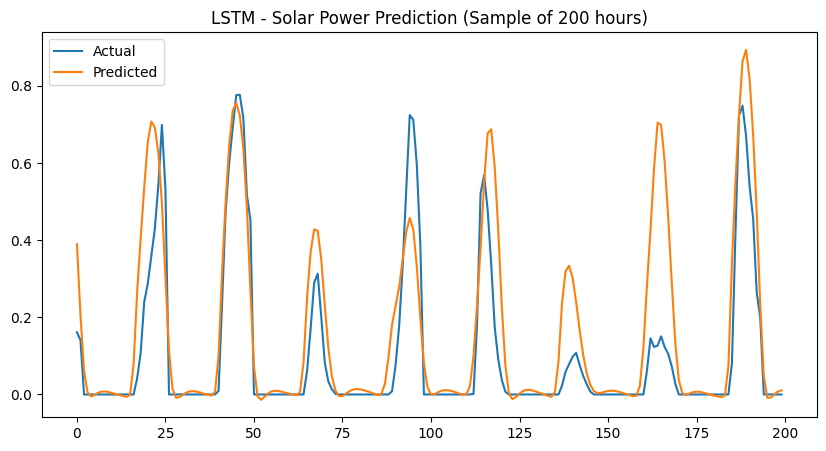

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

GRU Performance on Solar:
RMSE: 0.09, MAE: 0.06, R²: 0.797


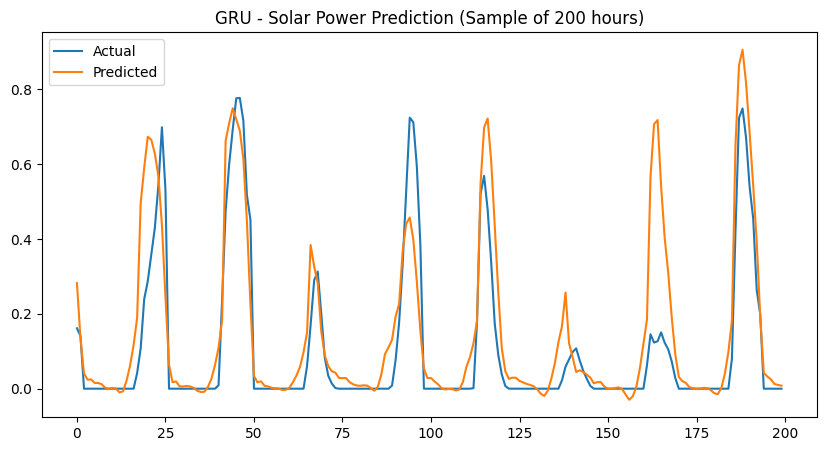

In [169]:
# Solar
results_dl.append(evaluate_dl(lstm_solar, X_test_solar, y_test_solar, "LSTM", "Solar"))
results_dl.append(evaluate_dl(gru_solar,  X_test_solar, y_test_solar, "GRU", "Solar"))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

LSTM Performance on Wind:
RMSE: 0.04, MAE: 0.03, R²: 0.971


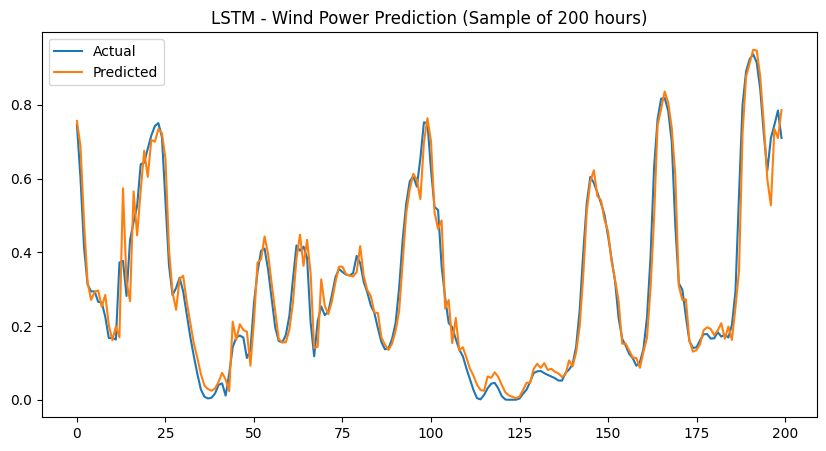

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

GRU Performance on Wind:
RMSE: 0.04, MAE: 0.02, R²: 0.971


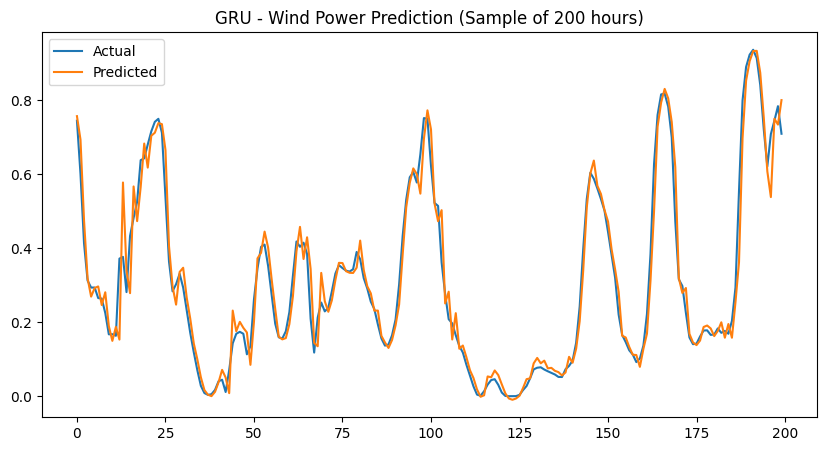

In [170]:
# Wind
results_dl.append(evaluate_dl(lstm_wind, X_test_wind, y_test_wind, "LSTM", "Wind"))
results_dl.append(evaluate_dl(gru_wind,  X_test_wind, y_test_wind, "GRU", "Wind"))

In [171]:
# Convert to DataFrame
results_dl_df = pd.DataFrame(results_dl)
print("\nFinal DL Results:\n", results_dl_df)


Final DL Results:
   Target Model      RMSE       MAE        R2
0  Solar  LSTM  0.107864  0.061559  0.732731
1  Solar   GRU  0.094045  0.055889  0.796829
2   Wind  LSTM  0.036486  0.025087  0.970756
3   Wind   GRU  0.036261  0.024417  0.971117


### **Comparison**

In [172]:
# Convert to DataFrames
results_ml_df = pd.DataFrame(results_ml)
results_dl_df = pd.DataFrame(results_dl)

# Combine
final_results = pd.concat([results_ml_df, results_dl_df], ignore_index=True)

# Show results
print("\n===== Final ML vs DL Comparison =====\n")
print(final_results)

# Save to CSV for research paper
final_results.to_csv("ML_DL_Comparison.csv", index=False)


===== Final ML vs DL Comparison =====

  Target          Model        RMSE         MAE        R2
0  Solar  Random Forest  390.483799  171.886996  0.864690
1  Solar        XGBoost  394.166178  178.854385  0.862126
2   Wind  Random Forest    0.662368    0.364053  1.000000
3   Wind        XGBoost    8.615146    5.012414  0.999940
4  Solar           LSTM    0.107864    0.061559  0.732731
5  Solar            GRU    0.094045    0.055889  0.796829
6   Wind           LSTM    0.036486    0.025087  0.970756
7   Wind            GRU    0.036261    0.024417  0.971117


In [175]:
# Original shape: (samples, timesteps, features)
X_train_solar, X_test_solar, y_train_solar, y_test_solar = ...

# Keep separate for ML and DL
X_train_solar_ml = X_train_solar.reshape(X_train_solar.shape[0], -1)
X_test_solar_ml  = X_test_solar.reshape(X_test_solar.shape[0], -1)

X_train_solar_dl, X_test_solar_dl = X_train_solar, X_test_solar

TypeError: cannot unpack non-iterable ellipsis object

In [173]:
def plot_comparison(y_test, preds_ml, preds_dl, target="Solar", model_ml="XGBoost", model_dl="LSTM", n=200):
    """
    Compare ML vs DL predictions with actual values.
    - y_test: actual test series
    - preds_ml: predictions from ML model
    - preds_dl: predictions from DL model
    - target: "Solar" or "Wind"
    - model_ml: ML model name (e.g., RF, XGB)
    - model_dl: DL model name (e.g., LSTM, GRU)
    - n: number of samples to plot
    """
    plt.figure(figsize=(12,6))
    plt.plot(y_test.values[:n], label="Actual", color="black", linewidth=2)
    plt.plot(preds_ml[:n], label=f"{model_ml} Prediction", linestyle="--")
    plt.plot(preds_dl[:n], label=f"{model_dl} Prediction", linestyle=":")

    plt.title(f"{target} Power Forecasting: Actual vs {model_ml} vs {model_dl} (Sample {n} hours)")
    plt.xlabel("Time Steps")
    plt.ylabel("Power Output")
    plt.legend()
    plt.grid(True)
    plt.show()

In [174]:
# Solar: XGBoost vs LSTM
preds_ml_solar = xgb_solar.predict(X_test_solar)
preds_dl_solar = lstm_solar.predict(X_test_solar.reshape(X_test_solar.shape[0], X_test_solar.shape[1], 1)).flatten()

plot_comparison(y_test_solar, preds_ml_solar, preds_dl_solar, target="Solar", model_ml="XGBoost", model_dl="LSTM")

ValueError: Feature shape mismatch, expected: 4, got 24

In [ ]:
# Wind: XGBoost vs GRU
preds_ml_wind = xgb_wind.predict(X_test_wind)
preds_dl_wind = gru_wind.predict(X_test_wind.reshape(X_test_wind.shape[0], X_test_wind.shape[1], 1)).flatten()

plot_comparison(y_test_wind, preds_ml_wind, preds_dl_wind, target="Wind", model_ml="XGBoost", model_dl="GRU")